# EDA: Comparison of Partial and Full Processing Extents

This notebook is an exploratory analyses that compares statistics between the partially processed and the fully processed (wall to wall) TML data. It focuses on Central America and West Africa.

**Area sampled (per land cover class)**
- The 'No Data (flag)' land cover classes is removed.
- We expect and see that the dark yellow bars are higher and the dark purple bars are smaller, indicating an increase in the sampling area during full processing. The most significant increases are in the tree cover (broadleaved/deciduous, broadleaved/evergreen) classes, as these were intentionally omitted in the initial processing extent.
- Additional labels for some land cover classes (same ESA label but different ESA ID number) were identified. This could result in a higher count of hectares for the sampled and total area for a land cover class if these labels were not previously identified.
- The no data glag is removed. If a land cover class does not appear in the visualization (a warning will print) the country did not have data for that land cover class in the initial processing, but does include that land cover class in the full processing.

**Total hectares of tree cover (per land cover class)**
- We expect and see the greatest differences in the tree cover (broadleaved/deciduous, broadleaved/evergreen) class. This is logical given the initial processing extent intentionally omitted these classes.
- We see an increase in the total hectares on cropland, which could be a result of the additional encoding/labeling of ESA ID's in that land cover category.
- Note: hectares of tree cover are not weighted by the percentage of tree cover within that hectare. A hectare with 10% tree cover is counted the same as a hectare with 90% tree cover.

**Forest cover compliant (per country)**
- In Central America, there's a fluctution of ~1% between the partial and full processing.


In [1]:
import os
import rasterio as rs
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd 
import pandas as pd
import fiona

from rasterio.plot import show
from numpy.ma import masked_array

## Area sampled (per land cover class)

In [2]:
def compare_lc_sampled(country):
    
    ## This needs to include a check for land cover class IDs that were missed in partial processing ##
    
    # get the full and partial processing extent for the country
    full_proc = pd.read_csv(f'comparisons/full_processing_area.csv')
    partial_proc = pd.read_csv(f'comparisons/partial_processing_area.csv')
    extent_full = full_proc[full_proc.country == country]
    extent_partial = partial_proc[partial_proc.country == country]
    
    full = pd.read_csv(f'comparisons/{country}_statistics_full.csv')
    partial = pd.read_csv(f'comparisons/{country}_statistics_partial.csv')

    # set up the dataframe and calculate the area sampled for the full
    full = full[['country', 'admin', 'esa_class', 'esa_id', 'esa_sampled_ha', 'esa_total_ha']]
    full = full.drop_duplicates(keep='first', ignore_index=True)
    full['esa_not_sampled'] = full['esa_total_ha'] - full['esa_sampled_ha']
    full = full.groupby(by=['esa_class']).sum().reset_index()
    full = full[full.esa_class != 'No Data (flag)']
    #full['esa_perc_sampled'] = round((full['esa_sampled_ha'] / full['esa_total_ha']) * 100, 1)

    # apply the same to the partial 
    partial = partial[['country', 'admin', 'esa_class','esa_id','esa_sampled_ha', 'esa_total_ha']]
    partial = partial.drop_duplicates(keep='first', ignore_index=True)
    partial['esa_not_sampled'] = partial['esa_total_ha'] - partial['esa_sampled_ha']
    partial = partial.groupby(by=['esa_class']).sum().reset_index()
    partial = partial[partial.esa_class != 'No Data (flag)']
    #partial['esa_perc_sampled'] = round((partial['esa_sampled_ha'] / partial['esa_total_ha']) * 100, 1)
    
    print(f'Processing extent for {country}:')
    print(f'Calculated extent sampled (full): {round(full.esa_sampled_ha.sum(),1)} ha')
    print(f'Actual extent sampled (full): {extent_full.full_area_ha.item()} ha')
          
    # check for differences in lccs sampled
    full_classes = list(full.esa_class.values)
    partial_classes = list(partial.esa_class.values)
    list_difference = [item for item in partial_classes if item not in full_classes]
    if len(list_difference) > 0:
        partial.drop(partial[partial.esa_class == list_difference[0]].index, inplace = True)
        print(f'{list_difference} caused shape mismatch and was dropped from the partial dataset.')

    # create the position of the grouped bars
    width = 0.4
    pos1 = np.arange(len(full))
    pos2 = pos1 + width

    plt.figure(figsize=(15,9))

    # create the position of the stacked bars
    classes = list(full.esa_class.values)
    bars1 = full.esa_sampled_ha
    bars2 = full.esa_not_sampled
    bars3 = partial.esa_sampled_ha
    bars4 = partial.esa_not_sampled

    plt.barh(pos1, bars1, width, color="gold", edgecolor='white', label='sampled (full)')  
    plt.barh(pos1, bars2, width, left=bars1, color="darkslateblue", edgecolor='white', label='not sampled (full)')
    #f3e151  #6c3376
    plt.barh(pos2, bars3, width, color="palegoldenrod", edgecolor='white', label='sampled (partial)')  
    plt.barh(pos2, bars4, width, left=bars3, color="slateblue", edgecolor='white', label='not sampled (partial)')

    plt.title(f'Land Cover Sampled in {country}')
    plt.xlabel('Tree Cover (ha)')
    plt.yticks(pos1 + width / 2, classes)
    plt.ticklabel_format(useOffset=False, style='plain', axis='x')
    plt.grid(axis='x', linestyle='-', linewidth=.2)
    plt.legend(loc='lower right');
    
    return None
    

Processing extent for El Salvador:
Calculated extent sampled (full): 1946488.1 ha
Actual extent sampled (full): 2066400 ha


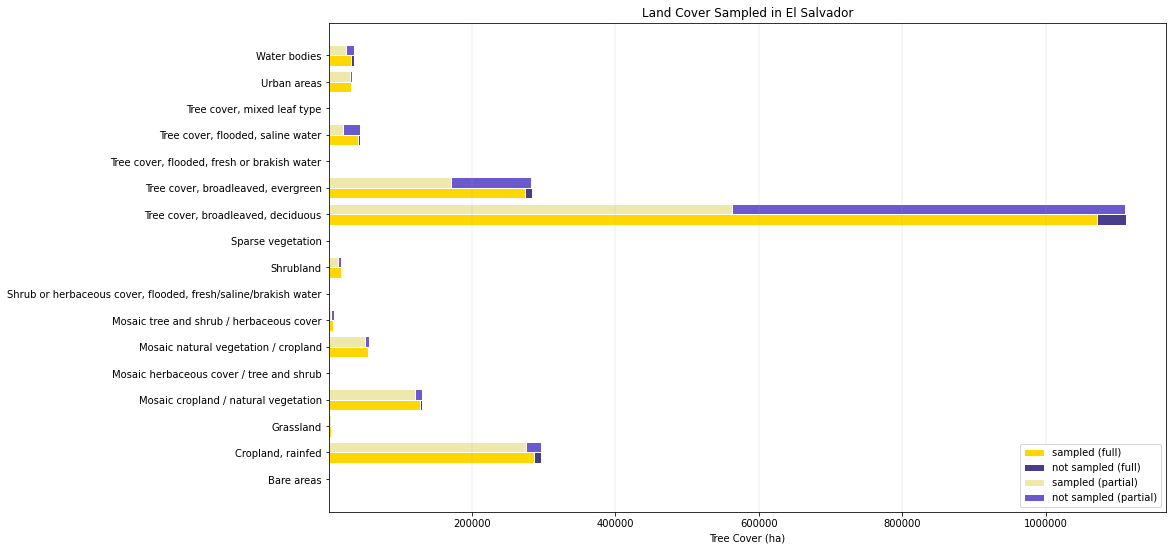

In [33]:
compare_lc_sampled('El Salvador')

Processing extent for Costa Rica:
Calculated extent sampled (full): 4966695.4 ha
Actual extent sampled (full): 5245200 ha


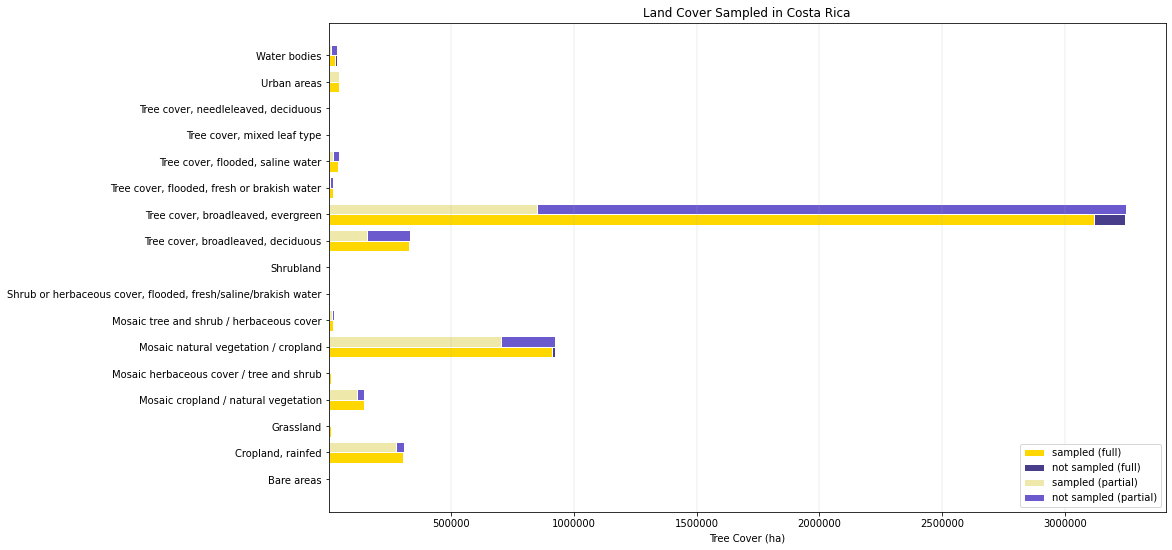

In [34]:
compare_lc_sampled('Costa Rica')

Processing extent for Belize:
Calculated extent sampled (full): 2165101.3 ha
Actual extent sampled (full): 2329200 ha


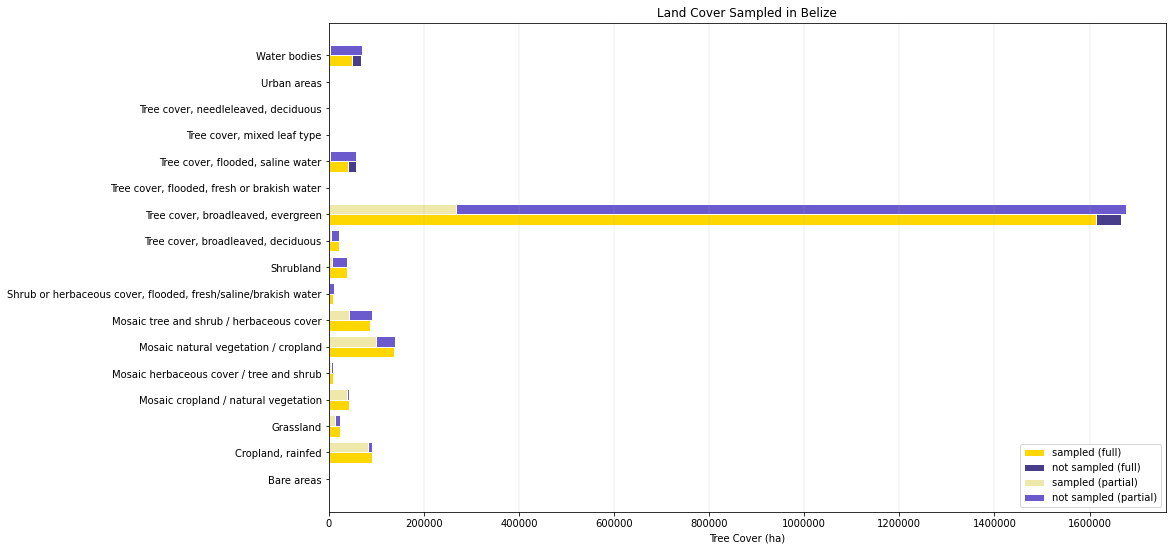

In [35]:
compare_lc_sampled('Belize')

Processing extent for Panama:
Calculated extent sampled (full): 7115242.0 ha
Actual extent sampled (full): 7779600 ha


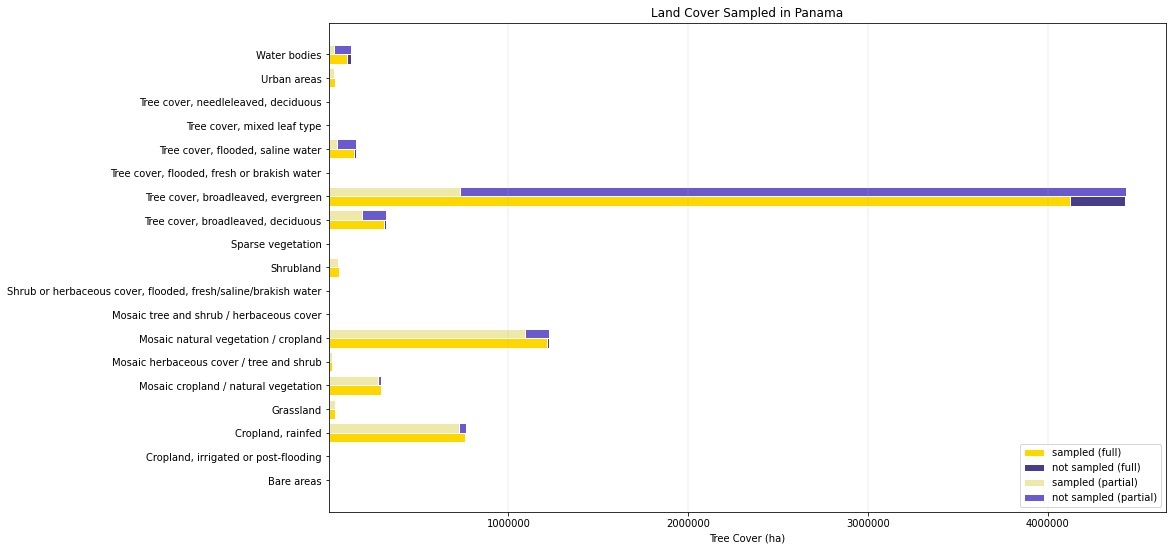

In [36]:
compare_lc_sampled('Panama')

Processing extent for Honduras:
Calculated extent sampled (full): 10273563.9 ha
Actual extent sampled (full): 11275200 ha


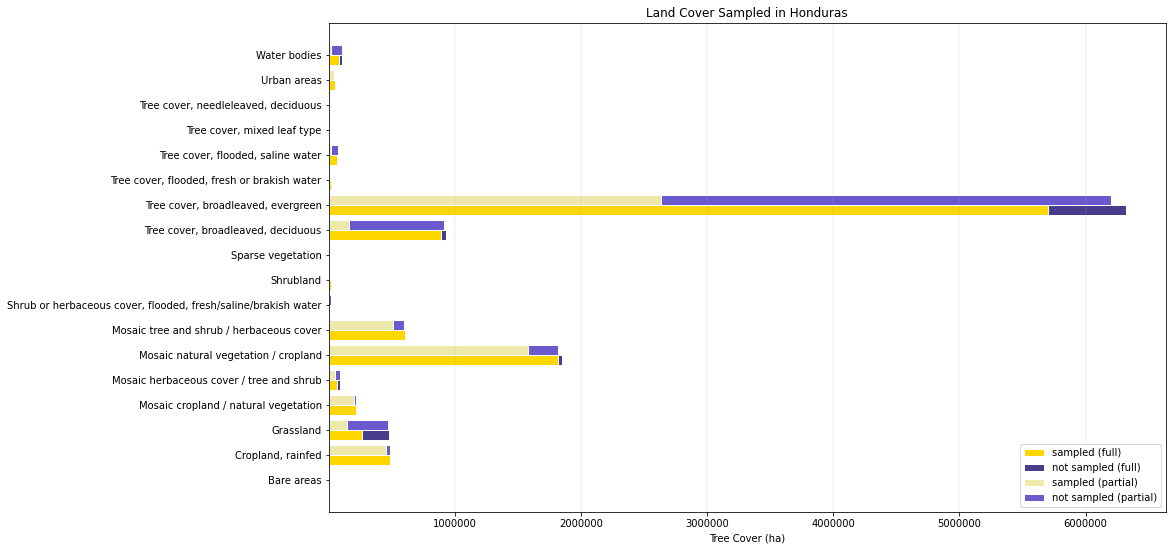

In [37]:
compare_lc_sampled('Honduras')

Processing extent for Nicaragua:
Calculated extent sampled (full): 11745106.3 ha
Actual extent sampled (full): 11970000 ha


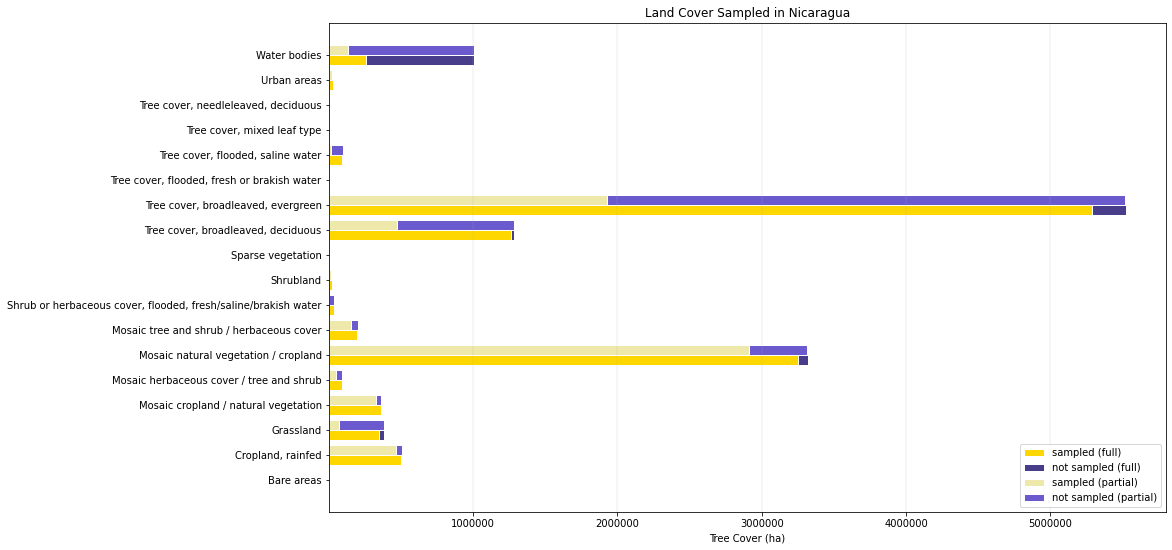

In [38]:
compare_lc_sampled('Nicaragua')

Processing extent for Guatemala:
Calculated extent sampled (full): 10620155.2 ha
Actual extent sampled (full): 10836000 ha


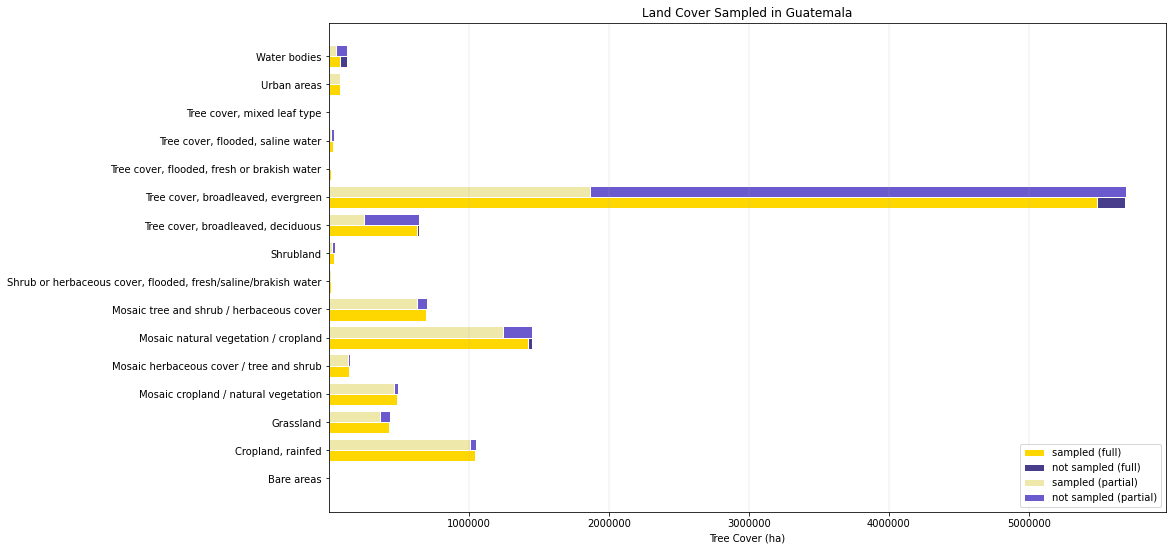

In [40]:
compare_lc_sampled('Guatemala')

## Total hectares of tree cover

In [62]:
def compare_lc_totalha(country):
    
    full = pd.read_csv(f'comparisons/{country}_statistics_full.csv')
    partial = pd.read_csv(f'comparisons/{country}_statistics.csv')
    
    full_sum = full.groupby('esa_class').sum()
    full_sum = full_sum[['tof_ha', 'hans_ha']]
    partial_sum = partial.groupby('esa_class').sum()
    partial_sum = partial_sum[['tof_ha', 'hans_ha']]

    diverge_sum = full_sum - partial_sum
    colors = ['red' if x < 0 else 'green' for x in diverge_sum.tof_ha]

    plt.figure(figsize=(15,7))
    plt.hlines(y=diverge_sum.index,
               xmin=0,
               xmax=diverge_sum.tof_ha,
               alpha=0.7,
               linewidth=7,
               colors=colors)
               #label=str(diverge_sum.tof_ha))
    
    plt.ticklabel_format(useOffset=False, style='plain', axis='x')
    plt.grid(axis='x', linestyle='-', linewidth=.2)
    plt.title(f'Difference in TML tree cover (hectares) per land cover class: {country}')
    plt.xlabel('tree cover (ha)');
    
    return None

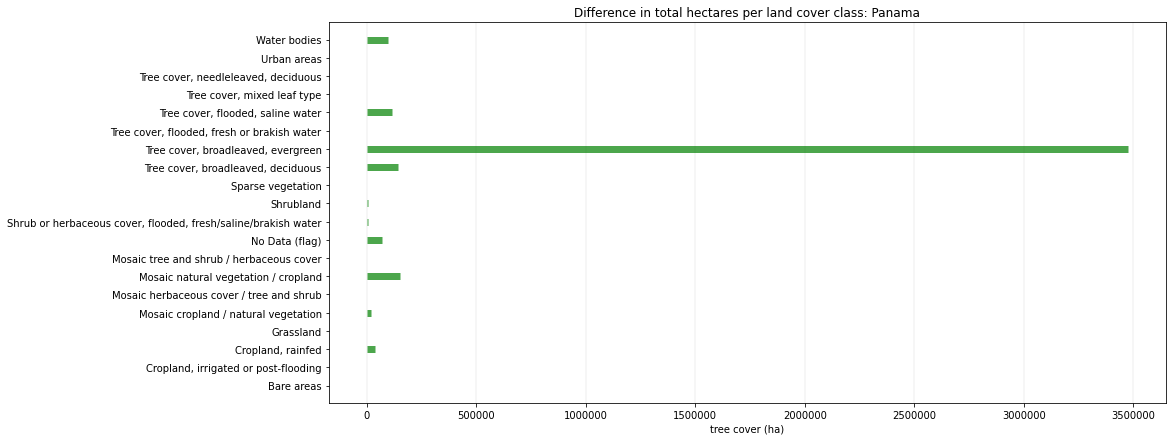

In [70]:
compare_lc_totalha('Panama')

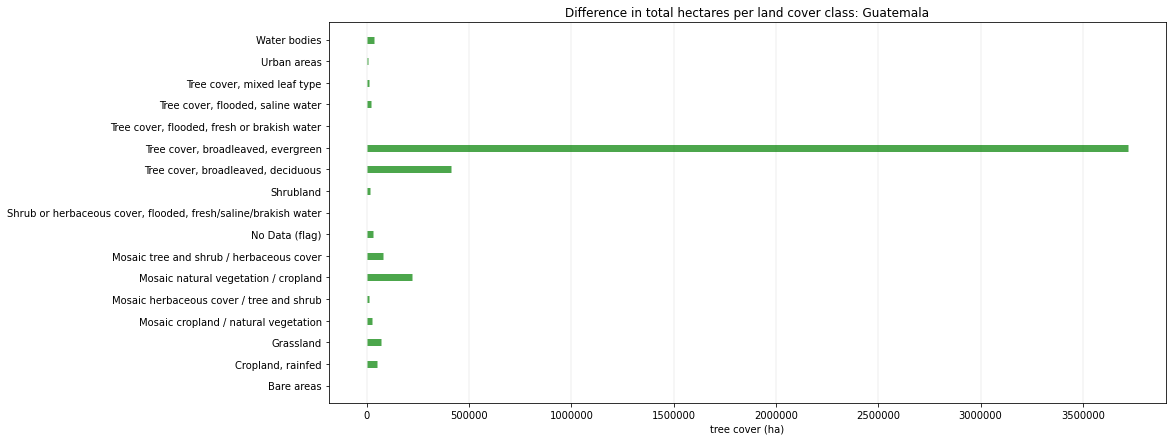

In [63]:
compare_lc_totalha('Guatemala')

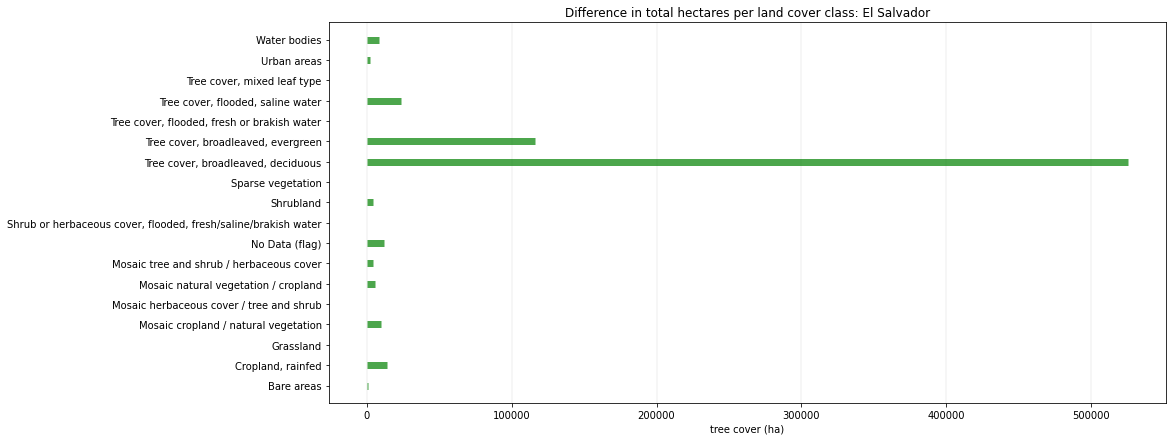

In [64]:
compare_lc_totalha('El Salvador')

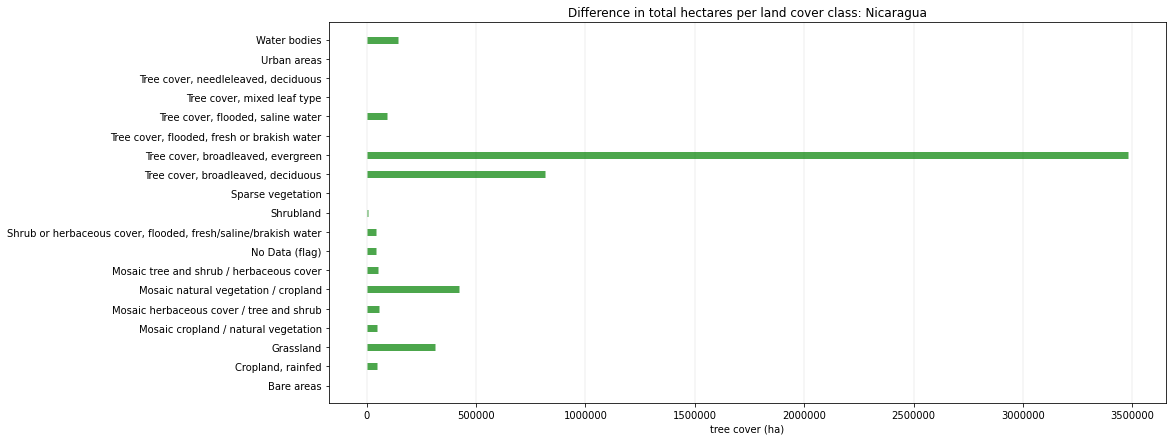

In [65]:
compare_lc_totalha('Nicaragua')

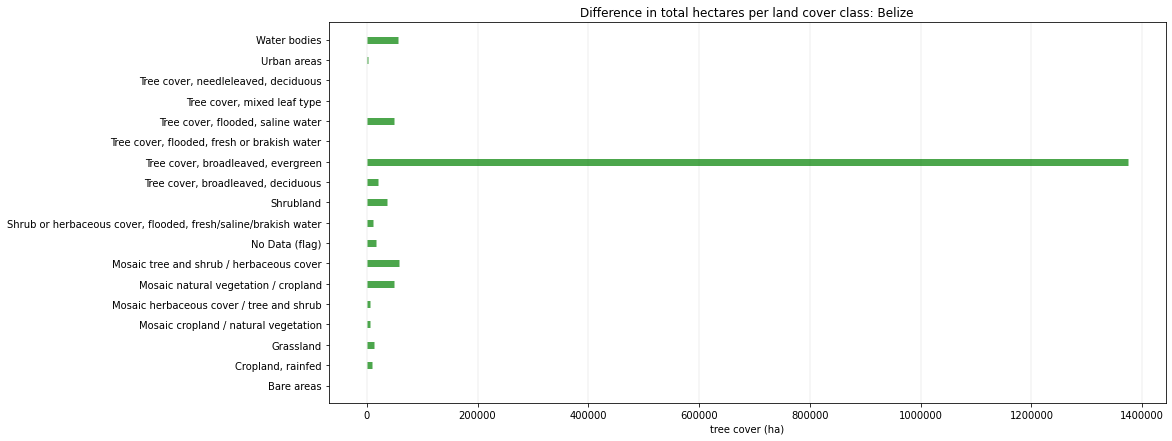

In [66]:
compare_lc_totalha('Belize')

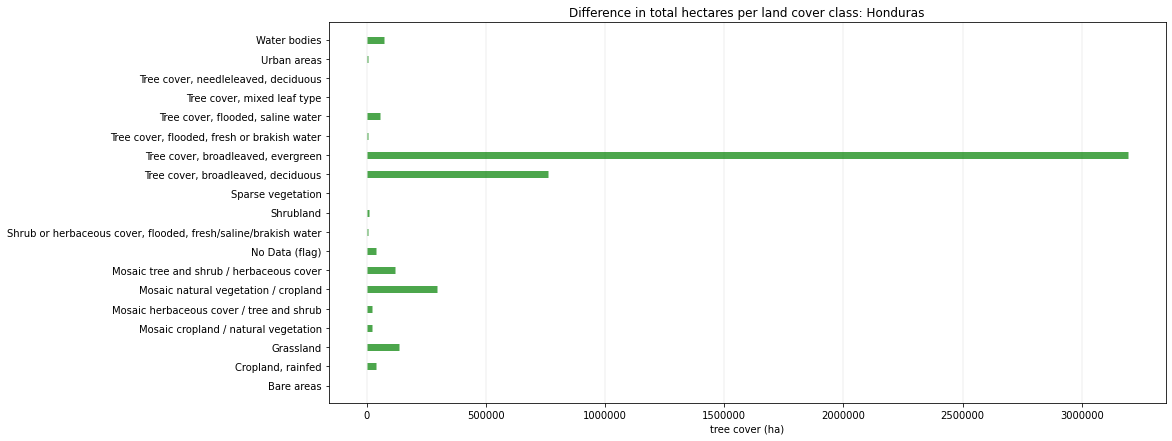

In [68]:
compare_lc_totalha('Honduras')

In [2]:
def compare_lc_mean(country):

    full = pd.read_csv(f'comparisons/{country}_statistics_full.csv')
    partial = pd.read_csv(f'comparisons/{country}_statistics.csv')

    full_mean = full.groupby('esa_class').mean()
    full_mean = full_mean[['tof_mean']]
    partial_mean = partial.groupby('esa_class').mean()
    partial_mean = partial_mean[['tof_mean']]
    mean_merged = full_mean.merge(partial_mean, on='esa_class')

    plt.figure(figsize=(12,8))

    width = 0.4
    pos1 = np.arange(len(mean_merged))
    pos2 = pos1 + width

    plt.barh(pos1, mean_merged.tof_mean_x, width, color='gold', edgecolor='white', label='Full')
    plt.barh(pos2, mean_merged.tof_mean_y, width, color='palegoldenrod', edgecolor='white', label='Partial')

    plt.xlabel('% Tree Cover')
    plt.yticks(pos1 + width / 2, mean_merged.index.values)
    plt.title(f'Mean Tree Cover per Land Cover Class: {country}')
    plt.grid(axis='x', linestyle='-', linewidth=.3)
    plt.legend();

    return None

## Forest Cover Compliant

In [3]:
def create_regional_csv(list_of_countries, region, extent):
    '''
    Merges the statistics for a list of countries into a single csv 
    file to permit regional analyses.
    '''
    
    regional_df = pd.DataFrame()
    dfs_to_concat = []
    
    for country in list_of_countries:
        country_df = pd.read_csv(f'comparisons/{country}_statistics_{extent}.csv')
        dfs_to_concat.append(country_df)
    
    regional_df = pd.concat(dfs_to_concat, ignore_index=True)
    regional_df.to_csv(f'comparisons/{region}_{extent}.csv', index=False)
    
    return None

In [79]:
# central america full processing
create_regional_csv(['Belize', 
                     'Honduras', 
                     'Guatemala', 
                     'El Salvador', 
                     'Costa Rica', 
                     'Nicaragua', 
                     'Panama'], 'central_america', 'full')

In [81]:
# central america partial processing
create_regional_csv(['Belize', 
                     'Honduras', 
                     'Guatemala', 
                     'El Salvador', 
                     'Costa Rica', 
                     'Nicaragua', 
                     'Panama'], 'central_america', 'partial')

In [4]:
# west africa full processing (missing Cape Verde, Ghana, Mali, Nigeria)
create_regional_csv(['Benin',
                    'Burkina Faso',
                    'Ivory Coast',
                    'Gambia',
                    'Guinea',
                    'Liberia',
                    'Mauritania',
                    'Niger',
                    'Senegal',
                    'Sierra Leone',
                    'Togo'], 'west_africa', 'full')

In [24]:
def compare_forest_cover_compliant(region, extent, figsize, rotation):
    
    region_df = pd.read_csv(f'comparisons/{region}_{extent}.csv')
    
    countries = list(set(region_df.country.values))

    x_labels, ag_bar1, ag_bar2, urban_bar1, urban_bar2 = [],[],[],[],[]
    
    for country in countries:
        
        # filter to one country and only urban/ag land cover classes
        country_df = region_df[region_df.country == country]
        ag_ids = [10.0, 11.0, 12.0, 20.0, 30.0, 40.0]
        urban_ids = [190.0]
        ag_df = country_df[country_df.esa_id.isin(ag_ids)].sort_values('country')
        urban_df = country_df[country_df.esa_id.isin(urban_ids)].sort_values('country')
        
        # get total tof ha per tree cover threshold
        ag_df = ag_df.groupby(by=['country', 'tree_cover_class']).sum().reset_index() 
        ag_df = ag_df[['country', 'tree_cover_class', 'tof_ha']] 
        urban_df = urban_df.groupby(by=['country', 'tree_cover_class']).sum().reset_index() 
        urban_df = urban_df[['country', 'tree_cover_class', 'tof_ha']] 
        
        # calculate # ha <10% tree cover and >10% tree cover
        ag_under10 = ag_df.tof_ha[0] 
        ag_over10 = sum(ag_df.tof_ha[1:])
        urban_under10 = urban_df.tof_ha[0]
        urban_over10 = sum(urban_df.tof_ha[1:])
        
        # normalize
        ag_under10_norm = ag_under10/(ag_under10 + ag_over10)*100
        ag_over10_norm = ag_over10/(ag_under10 + ag_over10)*100
        urban_under10_norm = urban_under10/(urban_under10 + urban_over10)*100
        urban_over10_norm = urban_over10/(urban_under10 + urban_over10)*100
        
        x_labels.append(country)
        ag_bar1.append(ag_over10_norm) # >10% is on the bottom
        ag_bar2.append(ag_under10_norm) # <10% is on the top
        urban_bar1.append(urban_over10_norm) 
        urban_bar2.append(urban_under10_norm) 
   
    # convert to array in order to add data labels
    ag_bar1 = np.asarray(ag_bar1)
    ag_bar2 = np.asarray(ag_bar2)
    urban_bar1 = np.asarray(urban_bar1)
    urban_bar2 = np.asarray(urban_bar2)

    plt.figure(figsize=figsize)
        
    # Ag plot
    plt.subplot(1,2,1)
    plt.bar(x_labels, ag_bar1, color="seagreen", label='>10% tree cover', capsize=4)  
    plt.bar(x_labels, ag_bar2, bottom=ag_bar1, color="honeydew", label='<10% tree cover')    
    
    # labels
    for xpos, ypos, yval in zip(x_labels, ag_bar1/2, ag_bar1):
        plt.text(xpos, ypos, f'{round(yval)}%', ha="center", va="center")
    for xpos, ypos, yval in zip(x_labels, ag_bar1 + ag_bar2/2, ag_bar2):
        plt.text(xpos, ypos, f'{round(yval)}%', ha="center", va="center")
    
    plt.xlabel(' ')
    plt.xticks(rotation=rotation)
    plt.ylabel('% Land')
    plt.ticklabel_format(style='plain', axis='y')
    plt.title(f'% Agricultural Land Meeting \n 10% Forest Cover Criteria \n ({extent})')
    plt.legend(loc='lower right')
    
    # Urban plot
    plt.subplot(1,2,2)
    plt.bar(x_labels, urban_bar1, color="seagreen", label='>10% tree cover', capsize=4)  
    plt.bar(x_labels, urban_bar2, bottom=urban_bar1, color="honeydew", label='<10% tree cover')    
    
    # labels
    for xpos, ypos, yval in zip(x_labels, urban_bar1/2, urban_bar1):
        plt.text(xpos, ypos, f'{round(yval)}%', ha="center", va="center")
    for xpos, ypos, yval in zip(x_labels, urban_bar1 + urban_bar2/2, urban_bar2):
        plt.text(xpos, ypos, f'{round(yval)}%', ha="center", va="center")
    
    
    plt.xlabel(' ')
    plt.xticks(rotation=rotation)
    plt.ylabel('% Land')
    plt.ticklabel_format(style='plain', axis='y')
    plt.title(f'% Urban Land Meeting \n 10% Forest Cover Criteria \n ({extent})')
    plt.legend(loc='lower right')
    plt.tight_layout(); 

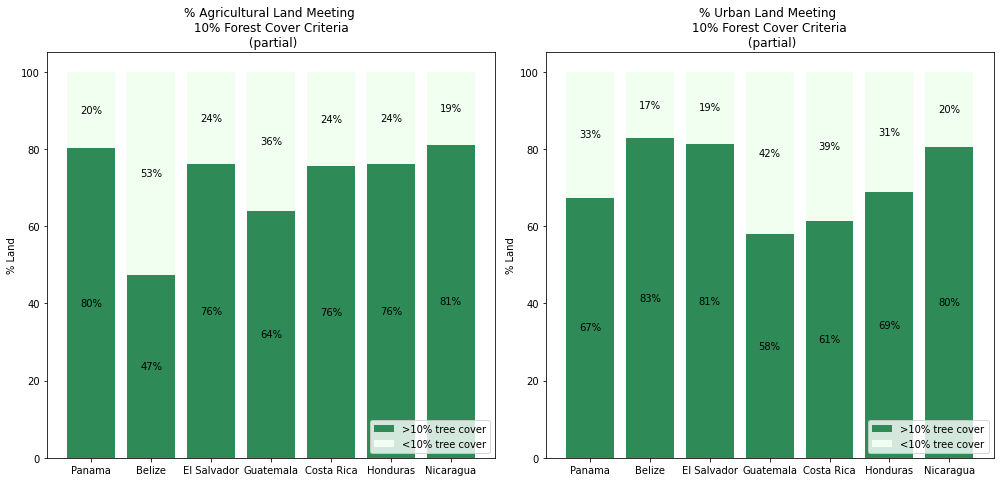

In [16]:
compare_forest_cover_compliant('central_america', 'partial', (14,7), 0)

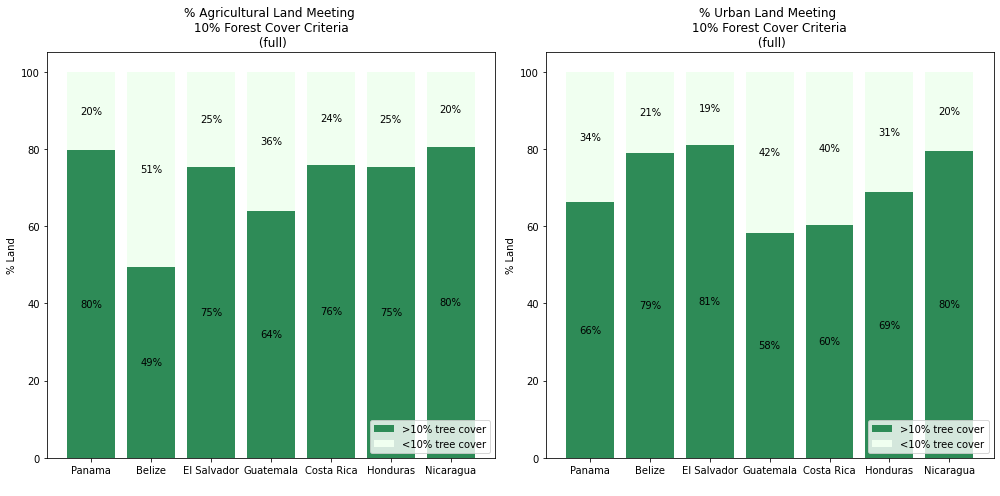

In [17]:
compare_forest_cover_compliant('central_america', 'full', (14,7), 0)

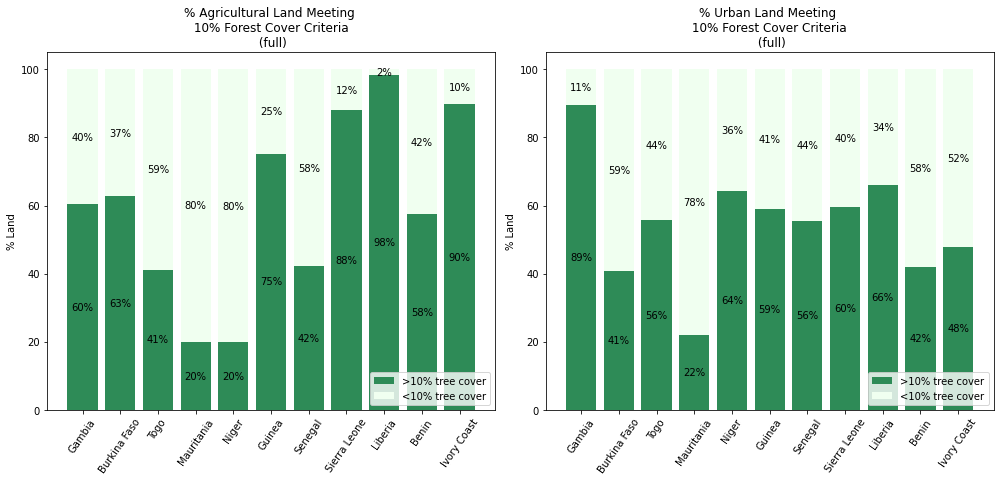

In [25]:
compare_forest_cover_compliant('west_africa', 'full', (14,7), 55)

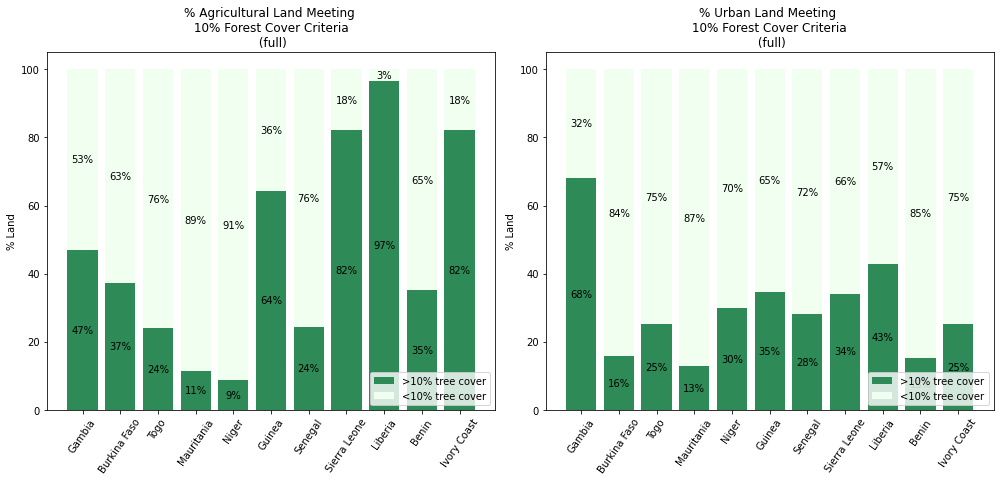

In [23]:
# >20%
compare_forest_cover_compliant('west_africa', 'full', (14,7), 55)

## Comparison w/ GFW analysis pipeline

In [ ]:
config = confuse.Configuration('sentinel-tree-cover')
config.set_file('/Users/jessica.ertel/sentinel-tree-cover/jessica-config.yaml')
api_token = config['rw']['token']

def get_gjson(country):
    
    # use pycountry to get country ISO
    iso = pycountry.countries.get(name = country).alpha_3
        
    # Get geostore object by ISO endpoint and GADM admin boundary 1
    url = (f'https://api.resourcewatch.org/v2/geostore/admin/{iso}/1')
    my_headers = {'Authorization': str(api_token)}
    response = requests.get(url=url, headers=my_headers)
    print(response)
    
    # save response as geojson
    data = response.json()
    print(data)
    geojson = data['data']['attributes']
    with open('test.geojson', 'w') as f:
        dump(geojson, f)
    
    return None

In [ ]:
# geostore id: bb7187a328ef7fc49e0f1c18b2964095
get_gjson('Sudan')

In [ ]:
# save geostore object (shapefile for al jazirah, sudan) to test
gadm_sudan = gpd.read_file('visualize/Sudan_adminboundaries.geojson')
geos_sudan = gpd.read_file('test.geojson')
gadm_sudan = gadm_sudan[gadm_sudan.NAME_1 == 'Al Jazirah']
geos_sudan['NAME_1'] = 'Al Jazirah'

In [ ]:
geos_sudan.to_file(f'Al Jazirah/Al Jazirah_adminboundaries.geojson', driver='GeoJSON')

In [ ]:
## Comparison
sudan = pd.read_csv('statistics/Sudan_statistics_full_tmlonly.csv')
sudan = sudan[sudan.admin == 'Al Jazirah']
al_jaz = pd.read_csv('Al Jazirah/stats/Al Jazirah_statistics_full_tmlonly.csv')

# check out a single land cover class
sudan = sudan[sudan.esa_id == 10]
al_jaz = al_jaz[al_jaz.esa_id == 10]